In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as Fun
import random
import pickle as pkl
import gzip

import games
import synthetic_data

In [2]:
class Evaluate:

    def __init__(self, ):
        pass

    def get_feedback(self, game, action, outcome ):
        return game.FeedbackMatrix[ action ][ outcome ]
        
    def deploy(self, game, horizon, alg, context_generator):

        history = [] 
        cumRegret =  []
        t = 0
        global_loss = []
        global_losses = []
        
        for t in range(horizon):
            
            context, distribution = context_generator.get_context()
            context = context.reshape( (1, -1) )
            outcome = 0 if distribution[0]<0.5 else 1
            # distribution = np.array([1-outcome, outcome])
            # print('distribution', distribution, 'outcome', outcome, )

            # print('context shape',context.shape)
            action, data = alg.get_action(t, context)

            data['context'] = context 
            history.append( data )

            feedback =  self.get_feedback( game, action, outcome )

            loss, losses = alg.update(action, feedback, outcome, t, context )

            global_loss.append(loss)
            global_losses.append(losses)

            i_star = np.argmin(  [ game.LossMatrix[i,...] @ np.array( distribution ) for i in range(alg.N) ]  )
            loss_diff = game.LossMatrix[action,...] - game.LossMatrix[i_star,...]
            val = loss_diff @ np.array( distribution )
            cumRegret.append( val )
            t+=1

            print('t', t, 'action', action, 'outcome', outcome, 'regret',val)
            print()
            
        return history, cumRegret, global_loss, global_losses

In [9]:
import cbpside
import rand_cbpside
import randneuralcbp_LE
import randneuralcbp_LE_exp3
import cesa_bianchi
import random_algo
import old_files.ineural as ineural
import ineural_multi
import margin_based
import neuralcbp_EE_binary
import neuralcbp_EE_kclasses_v3
import neuralcbp_EE_kclasses_v5

jobid = 24
np.random.seed(jobid)
torch.manual_seed(jobid)
torch.cuda.manual_seed(jobid)
random.seed(jobid)
m = 100
horizon = 9999

game = games.game_case1( {} )

##### train and test data:

context_generator = synthetic_data.MNISTcontexts_binary()
context_generator.initiate_loader()
# synthetic_data.QuinticContexts(  )
# context_generator = synthetic_data.QuinticContexts_imbalanced(  )
# context_generator.set_b(0)
# context_generator.normalization()


# nclasses = 2
# alg = random_algo.Egreedy(game, nclasses, m, 'cuda:0')
# alg.reset(context_generator.d)

# alg = cesa_bianchi.CesaBianchi(game, m, 'cuda:0')
# alg.reset(context_generator.d)

# alg = margin_based.MarginBased(game, m, 0.1,'cuda:0')
# alg.reset(context_generator.d)


# nclasses = 2
# alg = neuralcbp_EE_binary.CBPside( game, 1.01, m,  nclasses,  'cuda:0')
# alg.reset(context_generator.d)


nclasses = 2
alg = neuralcbp_EE_kclasses_v5.CBPside( game, 1.01, m,  nclasses,  'cuda:0')
alg.reset(context_generator.d)


# lbd_neural = 0
# lbd_reg = 1
# nclasses = 2
# alg = randneuralcbp_LE.CBPside( game, 1.01, lbd_neural, lbd_reg, 1, 10, 10e-7, m, H,  'cuda:0')
# alg.reset(context_generator.d)

# alg = ineural.INeurAL('cuda:0', horizon, 2)
# alg.reset(context_generator.d)

# budget = 9999
# nclasses = 2
# alg = ineural_multi.INeurALmulti(budget, nclasses, 'cuda:0')

alg.reset(context_generator.d)

# alg = margin_based.MarginBased(game, m, 0.1,  'cuda:0')
# alg.reset(context_generator.d)

evaluator = Evaluate()

num workers 1
input dim 500
Net1 has 78,904 trainable parameters.
Net2 has 50,504 trainable parameters.
input dim 500
Net1 has 78,904 trainable parameters.
Net2 has 50,504 trainable parameters.


In [10]:
history, cumRegret, global_loss, global_losses = evaluator.deploy(game, horizon, alg, context_generator)

P_t 1 [1] N_t []
union1 [1] R []
t 1 action 0 outcome 0 regret 1

P_t 1 [1] N_t []
union1 [1] R []
t 2 action 1 outcome 1 regret 1

P_t 1 [1] N_t []
union1 [1] R []
t 3 action 2 outcome 0 regret 1

P_t 1 [1] N_t []
union1 [1] R []
t 4 action 1 outcome 1 regret 1

P_t 1 [1] N_t []
union1 [1] R []
t 5 action 1 outcome 0 regret 0

P_t 1 [1] N_t []
union1 [1] R []
t 6 action 1 outcome 0 regret 0

P_t 1 [1] N_t []
union1 [1] R []
t 7 action 1 outcome 0 regret 0

P_t 1 [1] N_t []
union1 [1] R []
t 8 action 1 outcome 1 regret 1

step 3 b
P_t 2 [1, 2] N_t [[1, 2]]
union1 [1 2] R [0]
t 9 action 0 outcome 1 regret 1

P_t 2 [1, 2] N_t [[1, 2]]
union1 [1 2] R [0]
t 10 action 0 outcome 1 regret 1

P_t 1 [1] N_t []
union1 [1] R []
t 11 action 1 outcome 1 regret 1

P_t 2 [1, 2] N_t [[1, 2]]
union1 [1 2] R [0]
t 12 action 0 outcome 1 regret 1

P_t 1 [1] N_t []
union1 [1] R []
t 13 action 1 outcome 0 regret 0

P_t 2 [1, 2] N_t [[1, 2]]
union1 [1 2] R [0]


/home/mheuillet/Desktop/neuralCBPside/neuralcbp_EE_kclasses_v5.py:259: RuntimeWarning: divide by zero encountered in scalar divide
  if val > 1/rate :


t 14 action 0 outcome 1 regret 1

P_t 1 [2] N_t []
union1 [2] R []
t 15 action 2 outcome 0 regret 1

P_t 2 [1, 2] N_t [[1, 2]]
union1 [1 2] R [0]
t 16 action 0 outcome 0 regret 1

P_t 1 [2] N_t []
union1 [2] R []
t 17 action 2 outcome 0 regret 1

P_t 2 [1, 2] N_t [[1, 2]]
union1 [1 2] R [0]
t 18 action 0 outcome 0 regret 1

P_t 1 [1] N_t []
union1 [1] R []
t 19 action 1 outcome 1 regret 1

P_t 1 [1] N_t []
union1 [1] R []
t 20 action 1 outcome 0 regret 0

P_t 1 [2] N_t []
union1 [2] R []
t 21 action 2 outcome 1 regret 0

P_t 1 [2] N_t []
union1 [2] R []
t 22 action 2 outcome 0 regret 1

P_t 1 [1] N_t []
union1 [1] R []
t 23 action 1 outcome 0 regret 0

P_t 1 [1] N_t []
union1 [1] R []
t 24 action 1 outcome 0 regret 0

P_t 1 [2] N_t []
union1 [2] R []
t 25 action 2 outcome 1 regret 0

P_t 2 [1, 2] N_t [[1, 2]]
union1 [1 2] R [0]
t 26 action 0 outcome 0 regret 1

P_t 1 [1] N_t []
union1 [1] R []
t 27 action 1 outcome 0 regret 0

P_t 2 [1, 2] N_t [[1, 2]]
union1 [1 2] R [0]
t 28 action 0 

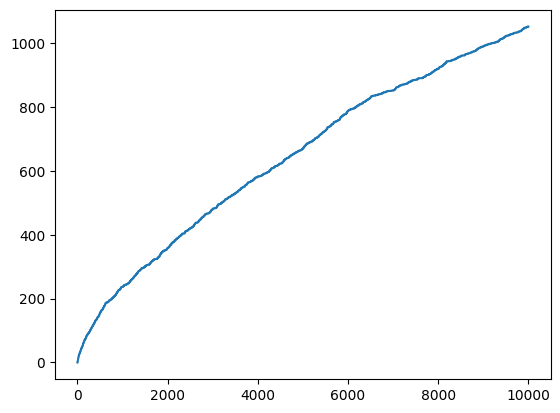

In [8]:
plt.plot( np.cumsum(cumRegret) )

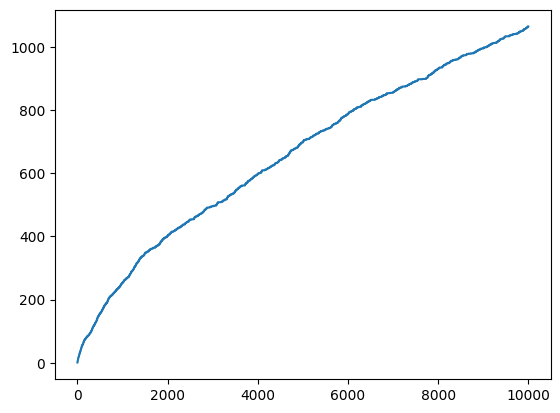

In [5]:
plt.plot( np.cumsum(cumRegret) )
# plt.ylim( (0,10000) )

In [ ]:
history, cumRegret, global_loss, global_losses = evaluator.deploy(game, horizon, alg, context_generator)

distribution [0, 1] outcome 0
context shape (1, 784)
estimate [array([0.24046578, 0.01048167]), array([0.06672549]), array([0.06672549])]
conf    [array(-0.01638731), array(-0.01773471), array(-0.01767838)]
P_t 1 [1] N_t []
union1 [1] R []
t 1 action 1 outcome 0 regret 0

distribution [1, 0] outcome 1
context shape (1, 784)
estimate [array([0.12527004, 0.03804868]), array([0.0966913]), array([0.0966913])]
conf    [array(-0.01529232), array(-0.01764519), array(-0.01762755)]
P_t 1 [1] N_t []
union1 [1] R []
t 2 action 1 outcome 1 regret 1

distribution [0, 1] outcome 0
context shape (1, 784)
estimate [array([ 0.11873636, -0.006305  ]), array([-0.04939059]), array([-0.04939059])]
conf    [array(-0.01782911), array(-0.01566913), array(-0.01564039)]
P_t 1 [1] N_t []
union1 [1] R []
t 3 action 1 outcome 0 regret 0

distribution [1, 0] outcome 1
context shape (1, 784)
estimate [array([0.03246528, 0.02574266]), array([-0.11424051]), array([-0.11424051])]
conf    [array(-0.01534393), array(-0.0

KeyboardInterrupt: 

In [ ]:
class Network_exploitation(nn.Module):

    def __init__(self, game, dim, hidden_size=100):
        super(Network_exploitation, self).__init__()
        self.game = game
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()

        self.heads = nn.ModuleDict()
        for k in range(self.game.N):
            sigma_i = len( np.unique(self.game.SignalMatrices[k]) )
            self.heads[str(k)] = nn.Linear(hidden_size, sigma_i)

    def forward(self, x):
        latent = self.fc1(x)
        x = self.activate(latent)
        outputs = {}
        for k in range(self.game.N):
            outputs[str(k)] = self.heads[str(k)](x)
        return outputs, latent
    


class Network_exploration(nn.Module):

    def __init__(self, game, dim, hidden_size=100):
        super(Network_exploration, self).__init__()
        self.game = game
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()

        self.heads = nn.ModuleDict()
        for k in range(game.N):
            sigma_i = len( np.unique(self.game.SignalMatrices[k]) )
            self.heads[str(k)] = nn.Linear(hidden_size, sigma_i)

    def forward(self, x):
        latent = self.fc1(x)
        x = self.activate(latent)
        outputs = {}
        for k in range(self.game.N):
            outputs[str(k)] = self.heads[str(k)](x)
        return outputs

def EE_forward(game, net1, net2, x):
    x.requires_grad = True
    f1, latent = net1(x)
    net1.zero_grad()

    gradients = []
    for k in range(game.N):
        # Compute backward pass for each head
        f1[str(k)].sum().backward(retain_graph=True)

        grad_last_layer = net1.heads[str(k)].weight.grad

        # Flatten and detach the gradient
        grad_flat = grad_last_layer.flatten().detach()

        # Store the gradient
        gradients.append(grad_flat)

        # Zero out gradients for the next head
        net1.zero_grad()

    gradients.append( latent[0].detach() )
    # print(gradients)

    dc = torch.cat(gradients)
    # print('dc', dc.shape)

    dc_normalized = dc / torch.linalg.norm(dc)
    f2 = net2(dc_normalized)

    return f1, f2, dc_normalized.to(torch.float16)

game = games.game_case1( {} )

m = 100
A = 4
d =  700

input_dim = m + m * A
print('input dim', input_dim)

net1 = Network_exploitation(game, d,m).to('cuda:0')

net2 = Network_exploration(game, input_dim, m).to('cuda:0')

x = torch.ones((1,700)).to('cuda:0')

f1, f2, dc_normalized  = EE_forward(game,net1, net2, x)




def convert_pred_format(pred):
    for k in range(game.N):
        pred[str(k)] = pred[str(k)].detach().cpu().numpy()
    return pred

def convert_conf_format(pred):
    for k in range(game.N):
        pred[str(k)] = pred[str(k)].detach().cpu().numpy()
        pred[str(k)] = np.array([max(pred[str(k)])])
    return pred

# convert_pred_format(f1)
convert_conf_format(f2)

input dim 500


{'0': array([0.09114568], dtype=float32),
 '1': array([-0.04335238], dtype=float32),
 '2': array([0.11573139], dtype=float32)}

In [ ]:
feedbacks = np.zeros( 1 )
feedbacks[feedback] = 1

tensor([ 0.0000,  0.0000,  0.0895,  0.1115,  0.0249,  0.0797,  0.0308,  0.0022,
         0.0000,  0.0000,  0.0270,  0.0000,  0.0000,  0.0000,  0.0538,  0.0000,
         0.0115,  0.0300,  0.0593,  0.0000,  0.0000,  0.0000,  0.0507,  0.0320,
         0.0201,  0.0556,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0731,  0.0681,  0.0072,  0.0334,  0.0308,  0.0845,  0.0000,
         0.0000,  0.0467,  0.0000,  0.0000,  0.0000,  0.0000,  0.0303,  0.0978,
         0.0012,  0.0000,  0.0046,  0.0000,  0.0000,  0.0995,  0.0000,  0.1377,
         0.0000,  0.0660,  0.0113,  0.0635,  0.0000,  0.0000,  0.0533,  0.0361,
         0.0000,  0.0000,  0.0107,  0.0000,  0.0000,  0.0316,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0491,  0.0798,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0408,  0.0000,  0.0000,  0.0118,  0.0000,  0.0288,
         0.0000,  0.0512,  0.0039,  0.0000,  0.0853,  0.1323,  0.0000,  0.0286,
         0.0373,  0.0000,  0.0000,  0.00

In [ ]:
f1['2'].detach().cpu().numpy()

array([[-0.19690196]], dtype=float32)

In [ ]:
result = [history, cumRegret]

with gzip.open( './results/LE_{}_{}.pkl.gz'.format(alg.name, horizon) ,'wb') as f:
    pkl.dump(result,f)

In [ ]:
horizon = 20000

with gzip.open( './results/LE_{}_{}.pkl.gz'.format('random',  horizon) ,'rb') as f:
    result1 = pkl.load(f)

with gzip.open( './results/LE_{}_{}.pkl.gz'.format('cesabianchi',  horizon) ,'rb') as f:
    result2 = pkl.load(f)

with gzip.open( './results/LE_{}_{}.pkl.gz'.format('randneuralcbp',  horizon) ,'rb') as f:
    result3 = pkl.load(f)

with gzip.open( './results/LE_{}_{}.pkl.gz'.format('ineural',  horizon) ,'rb') as f:
    result4 = pkl.load(f)

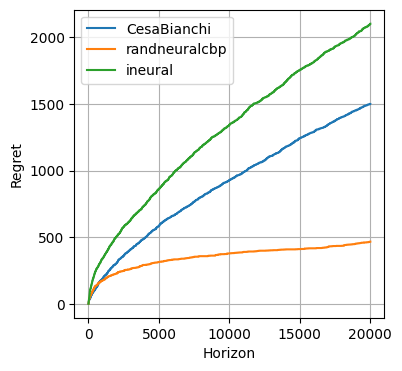

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
# plt.plot(np.cumsum(result1[1]), label = 'random', color = 'black')
plt.plot(np.cumsum(result2[1]), label = 'CesaBianchi')
plt.plot(np.cumsum(result3[1]), label = 'randneuralcbp')
plt.plot(np.cumsum(result4[1]), label = 'ineural')
plt.legend()
# plt.yscale('log')
plt.ylabel('Regret')
plt.xlabel('Horizon')
plt.grid()
# plt.ylim((0,1000))
# plt.xlim((0,2000))
plt.savefig('./figures/LE_results2.png', dpi=380, bbox_inches='tight')
# plt.savefig('./figures/CBP_regret4.png', dpi=380, bbox_inches='tight')
# plt.savefig('./figures/{}_regret4.png'.format(alg.name), dpi=380, bbox_inches='tight')

In [ ]:
train_hist = [sublist for sublist in history if sublist[3] is False]
depl_hist = [sublist for sublist in history if sublist[3] is True]

KeyError: 3

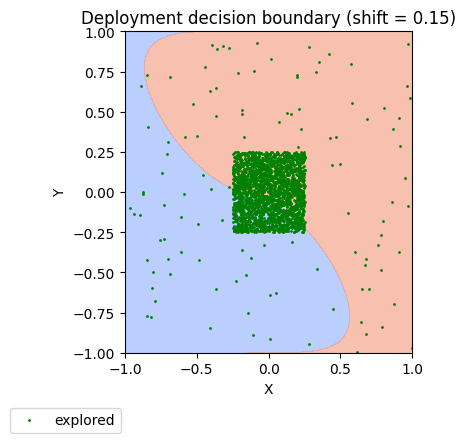

In [ ]:
# Define the range of x and y values for the grid
x_min, x_max = -1, 1
y_min, y_max = -1, 1

# Generate a grid of points
num_points = 1000
x_values = np.linspace(x_min, x_max, num_points)  
y_values = np.linspace(y_min, y_max, num_points)  
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Compute the decision boundary for the grid of points
b = 0.15

plt.figure(figsize=(4, 4))

decision_boundary_grid = context_generator.decision_boundary_function(x_grid, y_grid, b)
plt.contourf(x_grid, y_grid, decision_boundary_grid, levels=1, alpha=0.6, cmap=plt.cm.coolwarm)

contexts = np.array( [ context_generator.denormalize(i[4]) for i in train_hist ] ).squeeze(1) 

action0 = [ i[0] if i[0]==2 else np.nan for i in train_hist ]
indices_action0 = np.where(~np.isnan(action0))[0]
contexts0 = contexts[indices_action0]

action1 = [ i[0] if i[0]==1 else np.nan for i in train_hist ]
indices_action1 = np.where(~np.isnan(action1))[0]
contexts1 = contexts[indices_action1]

action2 = [ i[0] if i[0]==0 else np.nan for i in train_hist ]
indices_action2 = np.where(~np.isnan(action2))[0]
contexts2 = contexts[indices_action2]

# plt.plot(contexts0[:,0], contexts0[:,1], '.', color = 'orange', markersize = 2, label = 'predicted as class 1')
# plt.plot(contexts1[:,0], contexts1[:,1], '.', color = 'blue', markersize = 2, label = 'predicted as class 2')
plt.plot(contexts2[:,0], contexts2[:,1], '.', color = 'green', markersize = 2, label = 'explored')

plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.ylim((-1,1))
plt.xlim((-1,1))
# plt.title('Training decision boundary (shift = {})'.format(b))
plt.title('Deployment decision boundary (shift = {})'.format(b))
plt.legend(loc = (-0.4,-0.25),ncol = 3)
# Save the figure to a file with tight layout and 380 DPI
# plt.savefig('./figures/CBP_DB_{}.png'.format(b), dpi=380, bbox_inches='tight')
plt.savefig('./figures/ETC_exploration3_{}.png'.format(b), dpi=380, bbox_inches='tight')
# plt.savefig('./figures/CBP_exploration3_{}.png'.format(b), dpi=380, bbox_inches='tight')

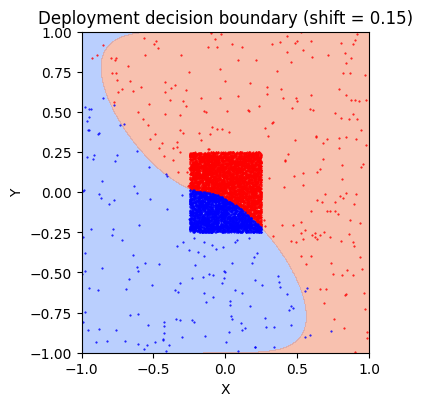

In [ ]:
# Define the range of x and y values for the grid
x_min, x_max = -1, 1
y_min, y_max = -1, 1

# Generate a grid of points
num_points = 1000
x_values = np.linspace(x_min, x_max, num_points)  
y_values = np.linspace(y_min, y_max, num_points)  
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Compute the decision boundary for the grid of points
for b in [0.15]: #[0, 0.15]

    plt.figure(figsize=(4, 4))

    decision_boundary_grid = context_generator.decision_boundary_function(x_grid, y_grid, b)

    plt.contourf(x_grid, y_grid, decision_boundary_grid, levels=1, alpha=0.6, cmap=plt.cm.coolwarm)

    contexts = np.array( [ context_generator.denormalize(i[4]) for i in depl_hist ] ).squeeze(1) 

    action0 = [ i[0] if i[0]==2 else np.nan for i in depl_hist ]
    indices_action0 = np.where(~np.isnan(action0))[0]
    contexts0 = contexts[indices_action0]
    action1 = [ i[0] if i[0]==1 else np.nan for i in depl_hist ]
    indices_action1 = np.where(~np.isnan(action1))[0]
    contexts1 = contexts[indices_action1]

    plt.plot(contexts0[:,0], contexts0[:,1], '.', markersize = 1, color = 'red')
    plt.plot(contexts1[:,0], contexts1[:,1], '.', markersize = 1, color = 'blue')

    # plt.scatter(contexts[indices_predaction0][:,0], contexts[indices_predaction0][:,1], s = 1, color='blue', label='Predicted Points')
    # plt.scatter(contexts[indices_predaction1][:,0], contexts[indices_predaction1][:,1], s = 1, color='red', label='Predicted Points')

    # Add labels and title to the plot
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.title(' Decision Boundary')
    # Adjust the layout for better spacing
    plt.tight_layout()
    plt.ylim((-1,1))
    plt.xlim((-1,1))
    plt.title('Deployment decision boundary (shift = {})'.format(b))

    # Save the figure to a file with tight layout and 380 DPI
    plt.savefig('./figures/ETC_exploitation3_{}.png'.format(b), dpi=380, bbox_inches='tight')
    # plt.savefig('./figures/CBP_exploitation3_{}.png'.format(b), dpi=380, bbox_inches='tight')

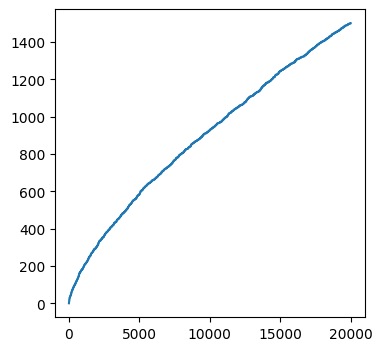

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.plot(np.cumsum(cumRegret))
# plt.ylim((0,3000))
# plt.savefig('./figures/ETC_regret3.png', dpi=380, bbox_inches='tight')
# plt.savefig('./figures/CBP_regret3.png', dpi=380, bbox_inches='tight')

Text(0, 0.5, 'Loss')

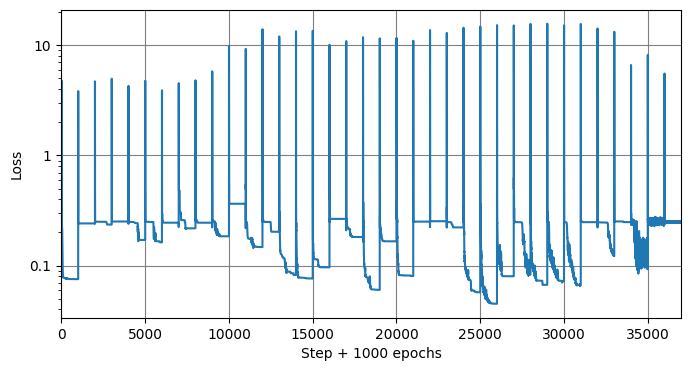

In [ ]:
from matplotlib.ticker import ScalarFormatter

new_global_loss = np.hstack( [ i for i in global_loss if len(i)>0 ] )

plt.figure(figsize=(8, 4))
# plt.ylim( (0, 10) )
plt.yscale('log')
plt.grid(color='gray', linestyle='-')
plt.xlim( (-10, len(new_global_loss)) )


def generate_custom_ticks(start, horizon, end, increment, label_increment):
    custom_ticks = list(range(start, end+1 , increment))
    custom_tick_labels = [ str(i) for i in range(start, horizon , label_increment)]
    return custom_ticks, custom_tick_labels

# Define the parameters
start_value = 0
end_value = len(new_global_loss) 
tick_increment = 1000
label_increment = 50
horizon = 1000

# custom_ticks, custom_tick_labels = generate_custom_ticks(start_value, horizon, end_value, tick_increment, label_increment)

# plt.xticks(custom_ticks, custom_tick_labels, rotation=45, fontsize=7)

# Set tick locations and labels for the y-axis
tick_locations = [0.01, 0.1, 1, 10,]  # Define your desired tick locations
tick_labels = ['0.01', '0.1', '1', '10', ]  # Corresponding labels
ax = plt.gca()
ax.yaxis.set_major_locator(plt.FixedLocator(tick_locations))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticklabels(tick_labels)

plt.plot( new_global_loss )
plt.xlabel('Step + 1000 epochs')
plt.ylabel('Loss')

# plt.savefig('./figures/loss_evolution.png', dpi=380, bbox_inches='tight')


NameError: name 'custom_ticks' is not defined

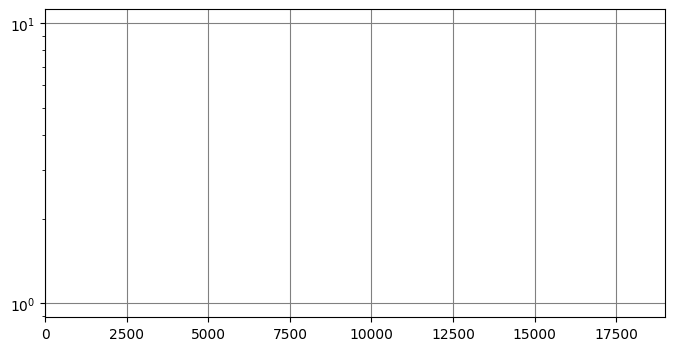

In [ ]:
from matplotlib.ticker import ScalarFormatter

new_global_loss = np.vstack( [ i for i in global_losses if len(i)>0 ] )

plt.figure(figsize=(8, 4))

plt.yscale('log')
plt.grid(color='gray', linestyle='-')
plt.xlim( (-10, 19000) )

plt.xticks(custom_ticks, custom_tick_labels, rotation=45)

# Set tick locations and labels for the y-axis
tick_locations = [0.01, 0.1, 1, 10,]  # Define your desired tick locations
tick_labels = ['0.01', '0.1', '1', '10', ]  # Corresponding labels
ax = plt.gca()
ax.yaxis.set_major_locator(plt.FixedLocator(tick_locations))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticklabels(tick_labels)

plt.plot( new_global_loss[:,0], label = 'symbole 0' )
plt.plot( new_global_loss[:,1], label = 'symbole 1' )
plt.plot( new_global_loss[:,2], label = 'symbole 2' )
plt.plot( new_global_loss[:,3], label = 'symbole 3' )

plt.xlabel('Step + 1000 epochs')
plt.ylabel('Loss')
plt.legend()

# plt.savefig('./figures/loss_evolution_{}.png'.format(idx), dpi=380, bbox_inches='tight')


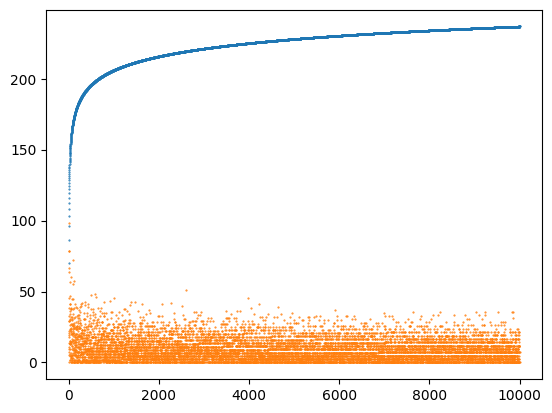

In [ ]:


def obtain_probability(t , factor):

    K = 100
    # sigma = K/(t+1)**(1/2)
    sigma = K/np.log(t+1)
    epsilon = 10e-7

    def divide_interval(start, end, k):
        intervals = np.linspace(start, end, k).tolist()
        return intervals

    # U = np.sqrt( self.alpha  * np.log(t) ) 

    U =  factor
    rhos = divide_interval(0, U, K)
    p_m_hat =  np.array([ np.exp( -rhos[i]**2 / ( 2*(sigma**2) )  )  for i in range(len(rhos)-1) ] )
    p_m = ( (1 - epsilon) * p_m_hat ) / p_m_hat.sum()
    p_m = p_m.tolist()
    p_m.append(epsilon)
        
    Z = np.random.choice(rhos, p= p_m)
    return Z

deterministic = []
rand = []

for t in range(1, 10000):
    sigma_i = 2
    d = 730
    N = 3
    H = 1
    lbd_reg = 1
    factor = sigma_i * (  np.sqrt( 2 * ( d  * np.log( 1 + t * np.log(N * H)/lbd_reg ) +  np.log(1/t**2) ) ) + np.sqrt(lbd_reg) * sigma_i )
    rand_value = obtain_probability(t , factor)
    deterministic.append(factor)
    rand.append(rand_value)


plt.plot(range(1,10000), deterministic, '.', markersize = 1)

plt.plot(range(1,10000), rand, '.', markersize = 1)

plt.savefig('vara2k100.png')

(array([1.362e+03, 7.500e+02, 1.380e+02, 1.900e+01, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.290e+02]),
 array([0.        , 0.90886871, 1.81773743, 2.72660614, 3.63547486,
        4.54434357, 5.45321229, 6.362081  , 7.27094972, 8.17981843,
        9.08868714]),
 <BarContainer object of 10 artists>)

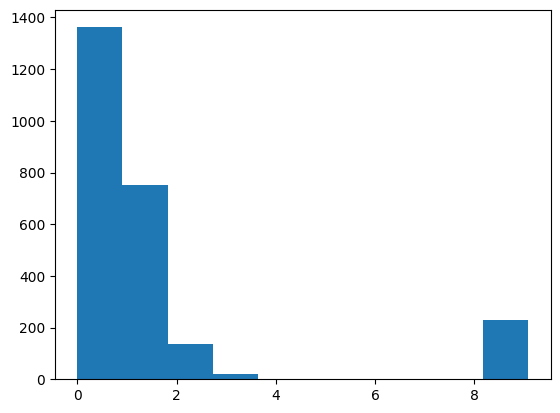

In [ ]:
plt.hist(rand, bins = 10)

In [ ]:
context_generator = synthetic_data.QuinticContexts(  )
context_generator.set_b(0)
context_generator.normalization()

V_it_inv = np.identity(20)

vals = []
rates = []

T = 10000

for t in range(1,T):

    norm_context, distribution = context_generator.get_context(True)
    dist_test.append(distribution)
    outcome = np.random.choice( 2 , p = distribution ) 

    latent_X = alg.func( torch.from_numpy( norm_context ).float().to(alg.device) ).cpu().detach().numpy()

    V_it_inv = V_it_inv - ( V_it_inv @ latent_X.T @ latent_X @ V_it_inv ) / ( 1 + latent_X @ V_it_inv @ latent_X.T ) 

    val =  latent_X @ V_it_inv @ latent_X.T  
    rate = t**(2/3)  * ( 1.01 * np.log(t) )**(1/3)

    vals.append(val[0][0])
    rates.append(1/rate)

plt.plot(range(1,T), vals, '.' , markersize = 0.01, color = 'blue', label = 'pseudo-count')
plt.plot(range(1,T), rates, '.', markersize = 0.01, color = 'red', label = 'exploration threshold')
plt.yscale('log')
plt.legend()

NameError: name 'synthetic_data' is not defined